In [1]:
import torch
import captum 
from Process_Data.audio_processing import read_WaveInt
from TrainAndTest.common_func import load_model_args
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [39]:
data = read_WaveInt('/home/yangwenhao/dataset/voxceleb2/dev/aac/id00012/21Uxsk56VDQ/00001.wav')
data = data[:, :160000]
print(data.shape)

(1, 150528)


In [40]:
baselines = []
with open('baselines.txt', 'r') as f:
    for l in f.readlines():
        uid, upath = l.split()
        the_data = read_WaveInt(upath)
        while the_data.shape[1] < data.shape[1]:
            the_data = np.concatenate([the_data, the_data], axis=1)
        
        the_data = trans(torch.tensor(the_data[:, :data.shape[1]]).reshape(1, 1, 1, -1).float())
        baselines.append(the_data)

In [41]:
baselines = torch.cat(baselines, dim=0)

In [4]:
model_kwargs = load_model_args('../../Data/checkpoint/ThinResNet34_ser07/Mean_batch128_cbam_downk5_avg0_SAP2_em256_dp01_alpha0_none1_chn32_wde4_varesmix8/arcsoft_sgd_rop/vox2/wave_sp161_dist/123456/model.2023.05.08.yaml')
if 'embedding_model' in model_kwargs:
    model = model_kwargs['embedding_model']
    if 'classifier' in model_kwargs:
        model.classifier = model_kwargs['classifier']
        
checkpoint = torch.load('../../Data/checkpoint/ThinResNet34_ser07/Mean_batch128_cbam_downk5_avg0_SAP2_em256_dp01_alpha0_none1_chn32_wde4_varesmix8/arcsoft_sgd_rop/vox2/wave_sp161_dist/123456/checkpoint_15.pth')
checkpoint_state_dict = checkpoint['state_dict']
if isinstance(checkpoint_state_dict, tuple):
    checkpoint_state_dict = checkpoint_state_dict[0]

filtered = {k: v for k, v in checkpoint_state_dict.items() if 'num_batches_tracked' not in k}
if list(filtered.keys())[0].startswith('module'):
    new_state_dict = OrderedDict()
    for k, v in filtered.items():
        name = k[7:]  # remove `module.`，表面从第7个key值字符取到最后一个字符，去掉module.
        new_state_dict[name] = v  # 新字典的key值对应的value为一一对应的值。

    model.load_state_dict(new_state_dict)
else:
    model_dict = model.state_dict()
    model_dict.update(filtered)
    model.load_state_dict(model_dict)

In [5]:
model = model.eval()

In [7]:
trans = model.input_mask[0]
model.input_mask.__delitem__(0)

In [8]:
model.return_embeddings = False

In [44]:
data = torch.tensor(data.reshape(1, 1, 1, -1)).float()
input_data = trans(data)

In [10]:
class model_forward():
    def __init__(self, model):
        self.model = model
        pass
    
    def __call__(self, data):
        logits,_ = self.model(data)
        
        return logits

In [11]:
def reverse(data):
    data = data.detach().squeeze().T.numpy()
    return np.flip(data, axis=0)

In [12]:
def plot_input_cam(data, cam):
    plt.figure(figsize=(8, 3))

    plt.subplot(2,1,1)
    plt.imshow(reverse(data))
    _ = plt.xticks([])
    _ = plt.yticks([])

    plt.subplot(2,1,2)
    plt.imshow(reverse(cam))
    _ = plt.xticks([])
    _ = plt.yticks([])
    plt.tight_layout()

### 1. Gradient

In [13]:
Saliency = captum.attr.Saliency(model_forward(model))

In [14]:
gradient = Saliency.attribute(input_data, target=0)

/home/yangwenhao/anaconda3/envs/py38/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


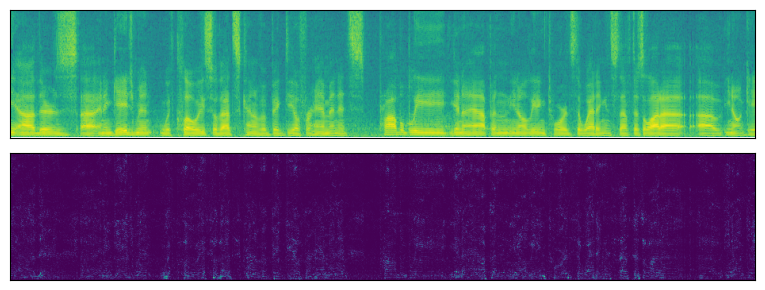

In [34]:
plot_input_cam(input_data, gradient)

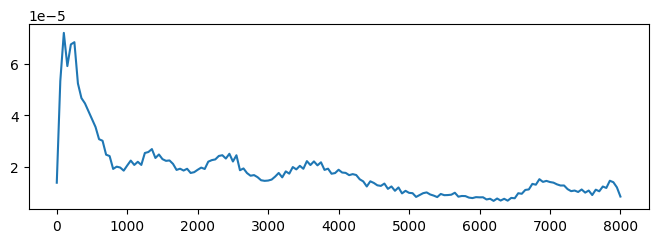

In [43]:
plt.figure(figsize=(8, 2.4))
x = np.linspace(0, 8000, 161)
plt.plot(x, gradient.detach().squeeze().mean(dim=0))

### 2. Input * Gradient

In [18]:
InputSaliency = captum.attr.InputXGradient(model_forward(model))

In [19]:
insa = InputSaliency.attribute(input_data, target=0)

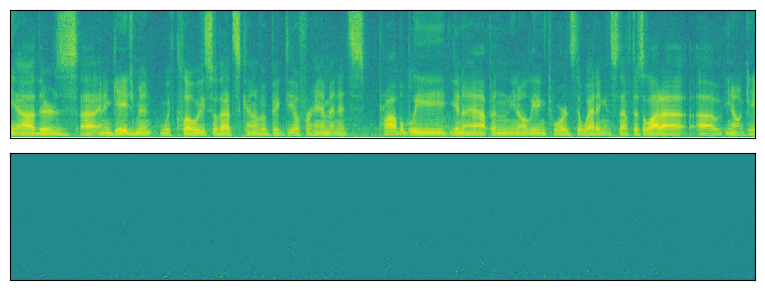

In [35]:
plot_input_cam(input_data, insa)

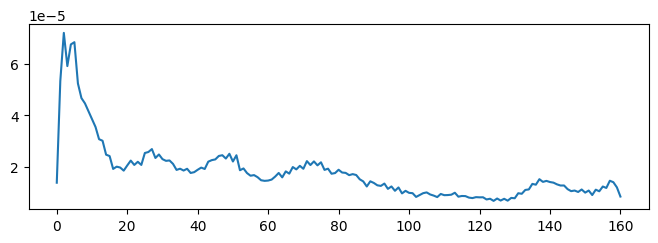

In [23]:
plt.figure(figsize=(8, 2.4))
x = np.linspace(0, 8000, 161)
plt.plot(x, gradient.detach().squeeze().mean(dim=0))

### 3. InteGrad

In [52]:
InteGrad = captum.attr.IntegratedGradients(model)

In [54]:
ingd = InteGrad.attribute(input_data, baselines.mean(dim=0, keepdim=True),
                          target=0)

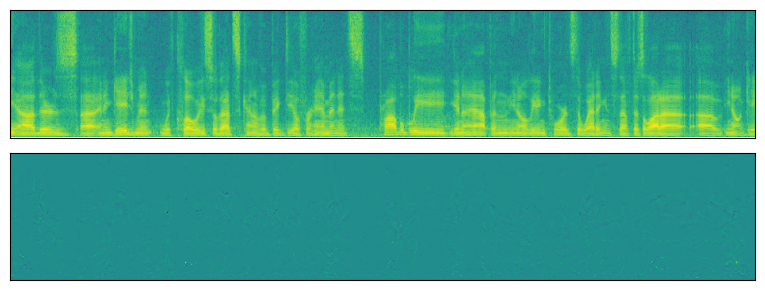

In [55]:
plot_input_cam(input_data, ingd)

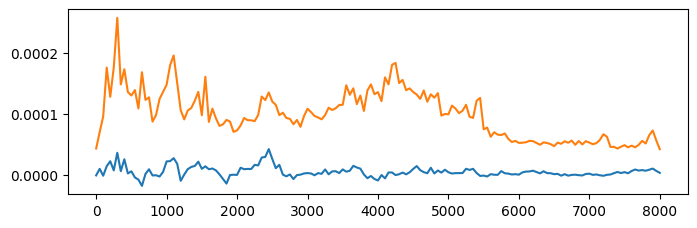

In [61]:
plt.figure(figsize=(8, 2.4))
x = np.linspace(0, 8000, 161)
plt.plot(x, ingd.detach().squeeze().mean(dim=0))
plt.plot(x, ingd.detach().squeeze().std(dim=0))

### 4. DeepLift

In [ ]:
deeplift = captum.attr.DeepLift(model)
dplf = deeplift.attribute(input_data, target=0)

In [ ]:
plot_input_cam(input_data, dplf)

In [ ]:
plt.figure(figsize=(8, 2.4))
x = np.linspace(0, 8000, 161)
plt.plot(x, dplf.detach().squeeze().mean(dim=0))

### 5. DeepLiftShap

In [ ]:
deepliftshp = captum.attr.DeepLiftShap(model)

dplp = deepliftshp.attribute(input_data, baselines, target=0)

In [ ]:
plt.figure(figsize=(8, 2.4))

x = np.linspace(0, 8000, 161)
plt.plot(x, dplp.detach().squeeze().mean(dim=0))

### 6. GradientShap

In [45]:
gradshap = captum.attr.GradientShap(model)

gdsp = gradshap.attribute(input_data, baselines, target=0)

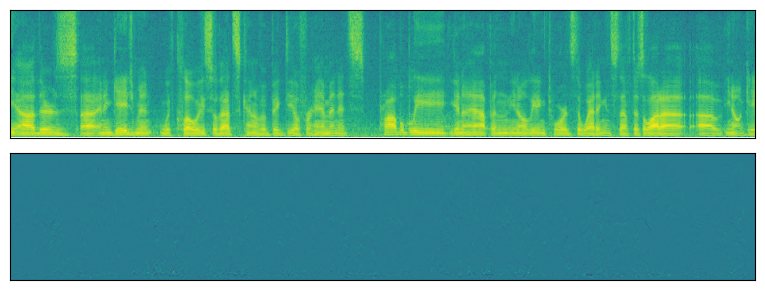

In [46]:
plot_input_cam(input_data, gdsp)

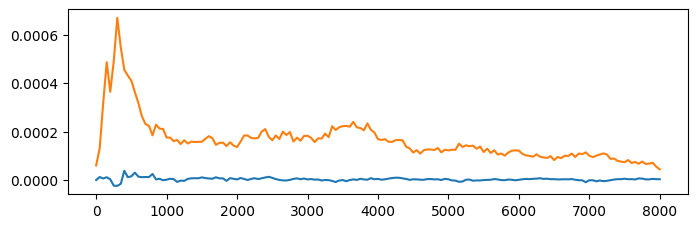

In [50]:
plt.figure(figsize=(8, 2.4))
x = np.linspace(0, 8000, 161)
plt.plot(x, gdsp.detach().squeeze().mean(dim=0))
plt.plot(x, gdsp.detach().squeeze().std(dim=0))